# NB11c: Extended Covering Set — Beyond the 48 Fitness Browser Organisms

**Goal**: Incorporate 25 non-FB organisms (with published TnSeq/CRISPRi resources) into
the Route B conservation-weighted covering set, expanding from 48 to 73 candidate organisms.

**Problem**: Both covering sets (NB09 Route A, NB11 Route B) draw only from 48 FB organisms,
which are 77% Pseudomonadota. Kingdom-level OGs (55.9% of dark gene OGs) span multiple phyla
but can only be experimentally addressed in Proteobacteria hosts.

**Approach**: 
1. Map each non-FB organism to GTDB species via genus-level pangenome query
2. Find which dark gene root_ogs have representatives in each non-FB organism's genus
3. Run conservation-weighted covering set with 73 organisms
4. Compare with FB-only covering set

**Key caveat**: For non-FB organisms, we use genus-level OG membership as a proxy (any species
in the same genus has the OG). This overestimates coverage but provides a reasonable planning
estimate. Exact coverage requires genome-specific annotation queries.

In [1]:
import os
import pandas as pd
import numpy as np
import time

DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), "data")
if not os.path.isdir(DATA_DIR):
    DATA_DIR = "data"
FIG_DIR = os.path.join(os.path.dirname(DATA_DIR), "figures")

# Load existing data
og_dist = pd.read_csv(os.path.join(DATA_DIR, "og_pangenome_distribution.tsv"), sep="\t")
og_importance = pd.read_csv(os.path.join(DATA_DIR, "og_importance_ranked.tsv"), sep="\t")
dark_classes = pd.read_csv(os.path.join(DATA_DIR, "dark_gene_classes.tsv"), sep="\t")
covering_fb = pd.read_csv(os.path.join(DATA_DIR, "conservation_covering_set.tsv"), sep="\t")
ext_orgs = pd.read_csv(os.path.join(DATA_DIR, "extended_tractable_organisms.tsv"), sep="\t")
exp_plans = pd.read_csv(os.path.join(DATA_DIR, "conservation_experiment_plans.tsv"), sep="\t")

print(f"OG distribution: {len(og_dist):,} root_ogs")
print(f"Dark gene classes: {len(dark_classes):,} genes")
print(f"FB covering set: {len(covering_fb)} organisms")
print(f"Extended organisms: {len(ext_orgs)} total ({ext_orgs['in_FB'].sum()} FB + {(~ext_orgs['in_FB']).sum()} non-FB)")

OG distribution: 11,774 root_ogs
Dark gene classes: 57,011 genes
FB covering set: 42 organisms
Extended organisms: 73 total (48 FB + 25 non-FB)


## Section 1: Query pangenome for non-FB organism OG coverage

For each non-FB organism genus, find which dark gene root_ogs have at least one gene cluster
in that genus across the full 27,690-species pangenome. This gives us genus-level OG membership.

In [2]:
from pyspark.sql import SparkSession

token = os.environ.get("KBASE_AUTH_TOKEN", "")
spark_url = f"sc://jupyter-aparkin.jupyterhub-prod:15002/;use_ssl=false;x-kbase-token={token}"

spark = SparkSession.builder.remote(spark_url).getOrCreate()
print("Spark session established")

Spark session established


In [3]:
# Register dark gene root_ogs as temp view
root_ogs = og_dist["root_og"].unique()
spark_root_ogs = spark.createDataFrame(pd.DataFrame({"root_og": root_ogs}))
spark_root_ogs.createOrReplaceTempView("target_root_ogs")
print(f"Registered {len(root_ogs):,} root_ogs")

# Get the genera we need to query
non_fb = ext_orgs[ext_orgs["in_FB"] == False].copy()
target_genera = non_fb["genus"].unique()
print(f"Non-FB genera to query: {len(target_genera)}")
print(f"  {', '.join(sorted(target_genera))}")

Registered 11,774 root_ogs
Non-FB genera to query: 24
  Acinetobacter, Bacillus, Burkholderia, Campylobacter, Chromobacterium, Clostridioides, Corynebacterium, Enterococcus, Erwinia, Francisella, Helicobacter, Klebsiella, Legionella, Listeria, Mycobacterium, Neisseria, Proteus, Pseudomonas, Salmonella, Serratia, Staphylococcus, Streptococcus, Vibrio, Yersinia


In [4]:
# Query: for each target genus, find which root_ogs have representatives
# Strategy: explode eggNOG_OGs, match to our root_ogs, join genus from taxonomy,
# filter to target genera

# Register target genera as temp view
genus_df = pd.DataFrame({"genus": target_genera})
spark_genera = spark.createDataFrame(genus_df)
spark_genera.createOrReplaceTempView("target_genera")

t0 = time.time()

genus_ogs = spark.sql("""
WITH exploded AS (
    SELECT
        ema.query_name as gene_cluster_id,
        split(og_entry, '@')[0] as og_id
    FROM kbase_ke_pangenome.eggnog_mapper_annotations ema
    LATERAL VIEW explode(split(ema.eggNOG_OGs, ',')) t AS og_entry
    WHERE ema.eggNOG_OGs IS NOT NULL
),
matched AS (
    SELECT DISTINCT
        tro.root_og,
        e.gene_cluster_id
    FROM exploded e
    JOIN target_root_ogs tro ON tro.root_og = e.og_id
),
with_genus AS (
    SELECT
        m.root_og,
        split(split(gsc.GTDB_taxonomy, ';')[5], '__')[1] as genus
    FROM matched m
    JOIN kbase_ke_pangenome.gene_cluster gc
        ON gc.gene_cluster_id = m.gene_cluster_id
    JOIN kbase_ke_pangenome.gtdb_species_clade gsc
        ON gsc.gtdb_species_clade_id = gc.gtdb_species_clade_id
)
SELECT
    genus,
    root_og,
    COUNT(*) as n_clusters
FROM with_genus
WHERE genus IN (SELECT genus FROM target_genera)
GROUP BY genus, root_og
""").toPandas()

elapsed = time.time() - t0
print(f"Query completed in {elapsed/60:.1f} min")
print(f"Rows: {len(genus_ogs):,}")
print(f"Genera found: {genus_ogs['genus'].nunique()}")
print(f"Root OGs found: {genus_ogs['root_og'].nunique():,}")

# Summary per genus
print(f"\nPer-genus OG coverage:")
for genus in sorted(target_genera):
    n = genus_ogs[genus_ogs["genus"] == genus]["root_og"].nunique()
    print(f"  {genus:25s}: {n:,} dark gene root_ogs")

Query completed in 2.9 min
Rows: 53,970
Genera found: 24
Root OGs found: 6,714

Per-genus OG coverage:
  Acinetobacter            : 3,111 dark gene root_ogs
  Bacillus                 : 1,920 dark gene root_ogs
  Burkholderia             : 4,010 dark gene root_ogs
  Campylobacter            : 1,148 dark gene root_ogs
  Chromobacterium          : 2,293 dark gene root_ogs
  Clostridioides           : 1,305 dark gene root_ogs
  Corynebacterium          : 1,751 dark gene root_ogs
  Enterococcus             : 1,728 dark gene root_ogs
  Erwinia                  : 2,532 dark gene root_ogs
  Francisella              : 1,084 dark gene root_ogs
  Helicobacter             : 711 dark gene root_ogs
  Klebsiella               : 3,615 dark gene root_ogs
  Legionella               : 1,674 dark gene root_ogs
  Listeria                 : 1,399 dark gene root_ogs
  Mycobacterium            : 2,496 dark gene root_ogs
  Neisseria                : 1,956 dark gene root_ogs
  Proteus                  : 2,144 

In [5]:
# Save genus-level OG mapping
genus_og_path = os.path.join(DATA_DIR, "non_fb_genus_og_coverage.tsv")
genus_ogs.to_csv(genus_og_path, sep="\t", index=False)
print(f"Saved {len(genus_ogs):,} genus-OG pairs to {genus_og_path}")

# Build organism-level OG sets
# For non-FB organisms, use their genus's OG set intersected with dark gene OGs
all_dark_ogs = set(og_dist["root_og"])
non_fb_org_ogs = {}
for _, row in non_fb.iterrows():
    genus = row["genus"]
    genus_root_ogs = set(genus_ogs[genus_ogs["genus"] == genus]["root_og"])
    org_dark_ogs = genus_root_ogs & all_dark_ogs
    non_fb_org_ogs[row["organism_name"]] = org_dark_ogs
    
print(f"\nNon-FB organism dark gene OG coverage (genus-level):")
for org in sorted(non_fb_org_ogs.keys(), key=lambda x: -len(non_fb_org_ogs[x])):
    info = non_fb[non_fb["organism_name"] == org].iloc[0]
    print(f"  {org[:45]:45s} {info['phylum']:20s} {len(non_fb_org_ogs[org]):>5,} OGs  tract={info['tractability_score']:.1f}")

Saved 53,970 genus-OG pairs to /home/aparkin/BERIL-research-observatory/projects/functional_dark_matter/data/non_fb_genus_og_coverage.tsv

Non-FB organism dark gene OG coverage (genus-level):
  Burkholderia cenocepacia K56-2                Pseudomonadota       4,010 OGs  tract=0.4
  Pseudomonas aeruginosa PAO1                   Pseudomonadota       3,713 OGs  tract=0.8
  Vibrio cholerae O1 El Tor N16961              Pseudomonadota       3,701 OGs  tract=0.7
  Vibrio parahaemolyticus RIMD 2210633          Pseudomonadota       3,701 OGs  tract=0.4
  Klebsiella pneumoniae KPNIH1                  Pseudomonadota       3,615 OGs  tract=0.5
  Acinetobacter baumannii ATCC 17978            Pseudomonadota       3,111 OGs  tract=0.6
  Salmonella enterica Typhimurium 14028s        Pseudomonadota       2,790 OGs  tract=0.7
  Serratia marcescens DB10                      Pseudomonadota       2,644 OGs  tract=0.4
  Yersinia pseudotuberculosis IP32953           Pseudomonadota       2,566 OGs  tract=0.

## Section 2: Extended Conservation-Weighted Covering Set

Run the greedy weighted set-cover with all 73 organisms (48 FB + 25 non-FB).
Same algorithm as NB11 but with expanded candidate pool.

In [6]:
# Build FB organism OG sets from dark_gene_classes
fb_org_ogs = {}
for _, row in dark_classes.iterrows():
    org = row.get("orgId", "")
    root = row.get("root_og", "")
    if pd.notna(org) and pd.notna(root) and str(root).strip() != "":
        if org not in fb_org_ogs:
            fb_org_ogs[org] = set()
        fb_org_ogs[org].add(str(root))

# Combine FB and non-FB organism OG sets
all_org_ogs = {}
all_org_ogs.update(fb_org_ogs)
all_org_ogs.update(non_fb_org_ogs)

# Build tractability map
tractability = {}
for _, row in ext_orgs.iterrows():
    if row["in_FB"]:
        # Extract FB orgId from notes
        notes = str(row.get("notes", ""))
        if "orgId=" in notes:
            org_id = notes.split("orgId=")[1].split(";")[0].strip()
            tractability[org_id] = row["tractability_score"]
    tractability[row["organism_name"]] = row["tractability_score"]

# Build genus map
org_genus = {}
for _, row in ext_orgs.iterrows():
    org_genus[row["organism_name"]] = row["genus"]
    notes = str(row.get("notes", ""))
    if "orgId=" in notes:
        org_id = notes.split("orgId=")[1].split(";")[0].strip()
        org_genus[org_id] = row["genus"]

# Build phylum map
org_phylum = {}
for _, row in ext_orgs.iterrows():
    org_phylum[row["organism_name"]] = row["phylum"]
    notes = str(row.get("notes", ""))
    if "orgId=" in notes:
        org_id = notes.split("orgId=")[1].split(";")[0].strip()
        org_phylum[org_id] = row["phylum"]

# Build is_FB map
is_fb = {}
for _, row in ext_orgs.iterrows():
    is_fb[row["organism_name"]] = row["in_FB"]
    notes = str(row.get("notes", ""))
    if "orgId=" in notes:
        org_id = notes.split("orgId=")[1].split(";")[0].strip()
        is_fb[org_id] = row["in_FB"]

# Importance per OG
og_imp = dict(zip(og_importance["root_og"], og_importance["mean_importance"]))

# All priority OGs
priority_ogs = set(og_imp.keys())
print(f"FB organisms with OG data: {len(fb_org_ogs)}")
print(f"Non-FB organisms with OG data: {len(non_fb_org_ogs)}")
print(f"Total candidate organisms: {len(all_org_ogs)}")
print(f"Priority OGs to cover: {len(priority_ogs):,}")

FB organisms with OG data: 48
Non-FB organisms with OG data: 25
Total candidate organisms: 73
Priority OGs to cover: 11,774


In [7]:
def run_covering_set(candidates, org_ogs_map, tract_map, genus_map, phylum_map,
                     priority_set, imp_map, max_orgs=50):
    """Greedy weighted set cover: sum(importance) × tractability × phylo_bonus."""
    uncovered = set(priority_set)
    selected = []
    genus_counts = {}
    phylum_counts = {}
    cumulative_genes = 0
    cumulative_importance = 0.0
    
    while uncovered and len(selected) < max_orgs:
        best_org = None
        best_score = -1
        best_new = set()
        best_genus = None
        best_phylum = None
        
        for org in candidates:
            if org in [s["org"] for s in selected]:
                continue
            covered_here = org_ogs_map.get(org, set()) & uncovered
            if not covered_here:
                continue
            
            imp_sum = sum(imp_map.get(og, 0) for og in covered_here)
            tract = tract_map.get(org, 0.3)
            genus = genus_map.get(org, "unknown")
            phylum = phylum_map.get(org, "unknown")
            
            # Genus penalty
            phylo_bonus = 1.0
            if genus_counts.get(genus, 0) > 0:
                phylo_bonus = 0.5 ** genus_counts[genus]
            # Phylum bonus for new phyla
            if phylum_counts.get(phylum, 0) == 0:
                phylo_bonus *= 1.5  # 50% bonus for first organism from a new phylum
            
            score = imp_sum * tract * phylo_bonus
            if score > best_score:
                best_score = score
                best_org = org
                best_new = covered_here
                best_genus = genus
                best_phylum = phylum
        
        if best_org is None:
            break
        
        n_new = len(best_new)
        imp_new = sum(imp_map.get(og, 0) for og in best_new)
        cumulative_genes += n_new
        cumulative_importance += imp_new
        
        # Count kingdom/phylum gaps in new OGs
        new_og_tiers = og_importance[og_importance["root_og"].isin(best_new)]
        n_kingdom = (new_og_tiers["taxonomic_tier"] == "kingdom").sum()
        n_phylum_tier = (new_og_tiers["taxonomic_tier"] == "phylum").sum()
        n_knowledge_gap = (new_og_tiers["hypothesis_status"] == "true_knowledge_gap").sum()
        n_weak_lead = (new_og_tiers["hypothesis_status"] == "weak_lead").sum()
        
        selected.append({
            "org": best_org,
            "genus": best_genus,
            "phylum": best_phylum,
            "tractability": tract_map.get(best_org, 0.3),
            "is_fb": is_fb.get(best_org, True),
            "n_new": n_new,
            "sum_importance": imp_new,
            "objective_value": best_score,
            "cumulative_genes": cumulative_genes,
            "cumulative_importance": cumulative_importance,
            "pct_covered": cumulative_genes / len(priority_set) * 100,
            "n_kingdom": n_kingdom,
            "n_phylum_tier": n_phylum_tier,
            "n_knowledge_gap": n_knowledge_gap,
            "n_weak_lead": n_weak_lead,
        })
        uncovered -= best_new
        if best_genus:
            genus_counts[best_genus] = genus_counts.get(best_genus, 0) + 1
        if best_phylum:
            phylum_counts[best_phylum] = phylum_counts.get(best_phylum, 0) + 1
    
    return pd.DataFrame(selected)

# FB-only candidates
fb_candidates = list(fb_org_ogs.keys())
# All candidates
all_candidates = fb_candidates + list(non_fb_org_ogs.keys())

print(f"Running FB-only covering set ({len(fb_candidates)} candidates)...")
fb_result = run_covering_set(
    fb_candidates, all_org_ogs, tractability, org_genus, org_phylum,
    priority_ogs, og_imp, max_orgs=48
)

print(f"Running extended covering set ({len(all_candidates)} candidates)...")
ext_result = run_covering_set(
    all_candidates, all_org_ogs, tractability, org_genus, org_phylum,
    priority_ogs, og_imp, max_orgs=50
)

print(f"\nFB-only: {len(fb_result)} organisms, {fb_result['pct_covered'].max():.1f}% coverage")
print(f"Extended: {len(ext_result)} organisms, {ext_result['pct_covered'].max():.1f}% coverage")

Running FB-only covering set (48 candidates)...
Running extended covering set (73 candidates)...



FB-only: 41 organisms, 100.0% coverage
Extended: 50 organisms, 98.7% coverage


In [8]:
# Compare the two covering sets
print("=" * 100)
print("Top 25 organisms: FB-only vs Extended")
print("=" * 100)
print(f"{'#':>3} | {'FB-only Org':>25} {'new':>5} {'cum%':>6} | {'Extended Org':>35} {'new':>5} {'cum%':>6} {'FB?':>4}")
print("-" * 100)
for i in range(25):
    fb_str = fb_result.iloc[i]["org"] if i < len(fb_result) else ""
    fb_new = str(int(fb_result.iloc[i]["n_new"])) if i < len(fb_result) else ""
    fb_pct = f"{fb_result.iloc[i]['pct_covered']:.1f}" if i < len(fb_result) else ""
    ext_str = ext_result.iloc[i]["org"][:35] if i < len(ext_result) else ""
    ext_new = str(int(ext_result.iloc[i]["n_new"])) if i < len(ext_result) else ""
    ext_pct = f"{ext_result.iloc[i]['pct_covered']:.1f}" if i < len(ext_result) else ""
    ext_fb = "FB" if i < len(ext_result) and ext_result.iloc[i]["is_fb"] else "NEW"
    print(f"{i+1:>3} | {fb_str:>25} {fb_new:>5} {fb_pct:>6} | {ext_str:>35} {ext_new:>5} {ext_pct:>6} {ext_fb:>4}")

# Non-FB organisms selected
non_fb_selected = ext_result[~ext_result["is_fb"]]
print(f"\nNon-FB organisms selected: {len(non_fb_selected)}")
for _, row in non_fb_selected.iterrows():
    step = ext_result.index.get_loc(row.name) + 1
    print(f"  #{step}: {row['org'][:45]} ({row['phylum']}, {int(row['n_new'])} new OGs, "
          f"{int(row['n_kingdom'])} kingdom, tract={row['tractability']:.1f})")

# Phyla coverage comparison
print(f"\nPhyla represented:")
fb_phyla = fb_result["phylum"].value_counts()
ext_phyla = ext_result["phylum"].value_counts()
all_phyla = set(fb_phyla.index) | set(ext_phyla.index)
for p in sorted(all_phyla):
    fb_n = fb_phyla.get(p, 0)
    ext_n = ext_phyla.get(p, 0)
    marker = " *** NEW" if fb_n == 0 and ext_n > 0 else ""
    print(f"  {p:25s}: FB={fb_n:>2}  Extended={ext_n:>2}{marker}")

Top 25 organisms: FB-only vs Extended
  # |               FB-only Org   new   cum% |                        Extended Org   new   cum%  FB?
----------------------------------------------------------------------------------------------------
  1 |                    Putida  1081    9.2 |         Pseudomonas aeruginosa PAO1  3713   31.5  NEW
  2 |                    Btheta  1086   18.4 |    Vibrio cholerae O1 El Tor N16961  1049   40.4  NEW
  3 |                     Smeli   914   26.2 |                              Btheta   691   46.3   FB
  4 |                       MR1   654   31.7 |      Burkholderia cenocepacia K56-2   956   54.4  NEW
  5 |                     BFirm   754   38.1 |                               Smeli   384   57.7   FB
  6 |                      Koxy   292   40.6 |    Mycobacterium tuberculosis H37Rv   131   58.8  NEW
  7 |                      SynE   411   44.1 |                                 MR1   244   60.9   FB
  8 |                       DvH   351   47.1 |       

/tmp/ipykernel_94437/4011201300.py:22: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend(handles=ax.get_legend_handles_labels()[1] + [red_star],


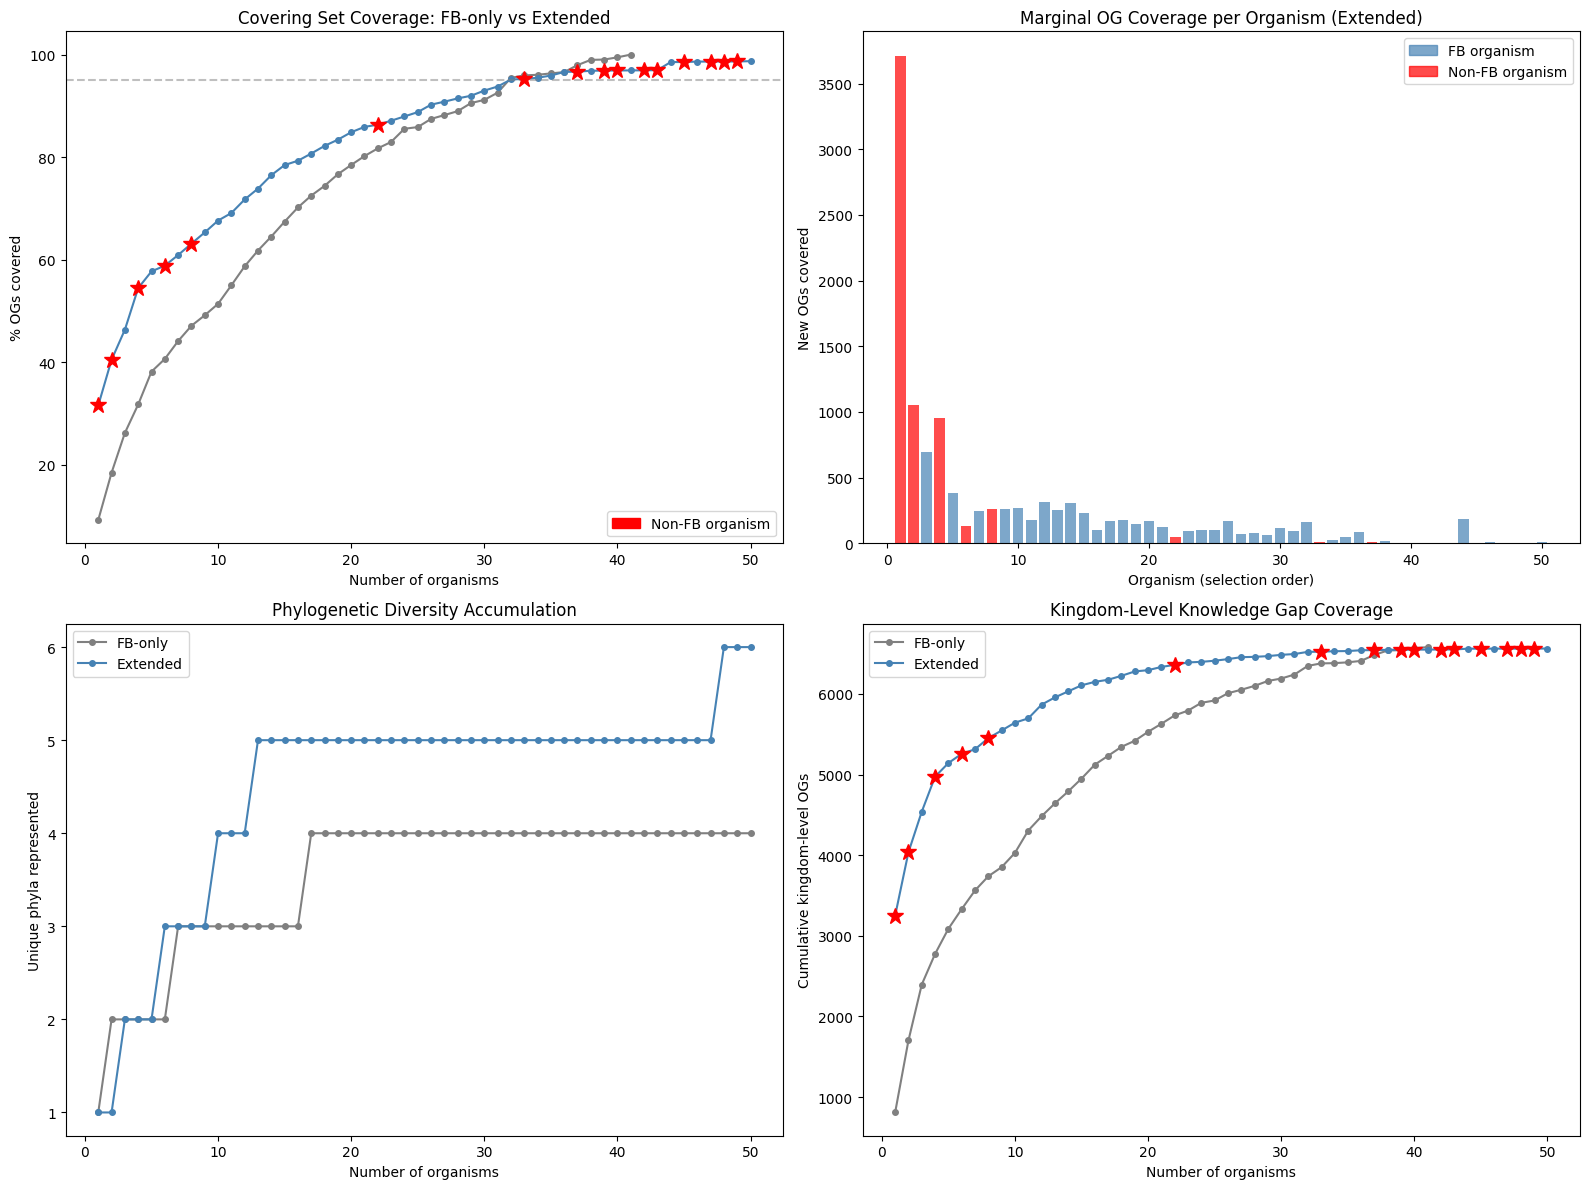

Saved to /home/aparkin/BERIL-research-observatory/projects/functional_dark_matter/figures/fig39_extended_covering_set.png


In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Coverage curves: FB-only vs Extended
ax = axes[0, 0]
ax.plot(range(1, len(fb_result)+1), fb_result["pct_covered"], "o-", color="gray",
        label=f"FB-only ({len(fb_result)} orgs)", markersize=4)
ax.plot(range(1, len(ext_result)+1), ext_result["pct_covered"], "o-", color="steelblue",
        label=f"Extended ({len(ext_result)} orgs)", markersize=4)
# Highlight non-FB organisms
for idx, row in ext_result.iterrows():
    if not row["is_fb"]:
        ax.plot(idx+1, row["pct_covered"], "*", color="red", markersize=12, zorder=5)
ax.axhline(y=95, color="gray", linestyle="--", alpha=0.5)
ax.set_xlabel("Number of organisms")
ax.set_ylabel("% OGs covered")
ax.set_title("Covering Set Coverage: FB-only vs Extended")
ax.legend(loc="lower right")
red_star = mpatches.Patch(color="red", label="Non-FB organism")
ax.legend(handles=ax.get_legend_handles_labels()[1] + [red_star],
          labels=[f"FB-only ({len(fb_result)} orgs)", f"Extended ({len(ext_result)} orgs)", "Non-FB organism"],
          loc="lower right")

# 2. Marginal genes per organism
ax = axes[0, 1]
colors = ["red" if not row["is_fb"] else "steelblue" for _, row in ext_result.iterrows()]
ax.bar(range(1, len(ext_result)+1), ext_result["n_new"], color=colors, alpha=0.7)
ax.set_xlabel("Organism (selection order)")
ax.set_ylabel("New OGs covered")
ax.set_title("Marginal OG Coverage per Organism (Extended)")
fb_patch = mpatches.Patch(color="steelblue", alpha=0.7, label="FB organism")
new_patch = mpatches.Patch(color="red", alpha=0.7, label="Non-FB organism")
ax.legend(handles=[fb_patch, new_patch])

# 3. Phylum diversity comparison
ax = axes[1, 0]
fb_phylum_cum = []
ext_phylum_cum = []
fb_seen = set()
ext_seen = set()
for i in range(max(len(fb_result), len(ext_result))):
    if i < len(fb_result):
        fb_seen.add(fb_result.iloc[i]["phylum"])
    if i < len(ext_result):
        ext_seen.add(ext_result.iloc[i]["phylum"])
    fb_phylum_cum.append(len(fb_seen))
    ext_phylum_cum.append(len(ext_seen))
ax.plot(range(1, len(fb_phylum_cum)+1), fb_phylum_cum, "o-", color="gray",
        label="FB-only", markersize=4)
ax.plot(range(1, len(ext_phylum_cum)+1), ext_phylum_cum, "o-", color="steelblue",
        label="Extended", markersize=4)
ax.set_xlabel("Number of organisms")
ax.set_ylabel("Unique phyla represented")
ax.set_title("Phylogenetic Diversity Accumulation")
ax.legend()

# 4. Kingdom-level gap coverage
ax = axes[1, 1]
fb_kingdom_cum = fb_result["n_kingdom"].cumsum()
ext_kingdom_cum = ext_result["n_kingdom"].cumsum()
ax.plot(range(1, len(fb_result)+1), fb_kingdom_cum, "o-", color="gray",
        label="FB-only", markersize=4)
ax.plot(range(1, len(ext_result)+1), ext_kingdom_cum, "o-", color="steelblue",
        label="Extended", markersize=4)
for idx, row in ext_result.iterrows():
    if not row["is_fb"]:
        ax.plot(idx+1, ext_kingdom_cum.iloc[idx], "*", color="red", markersize=12, zorder=5)
ax.set_xlabel("Number of organisms")
ax.set_ylabel("Cumulative kingdom-level OGs")
ax.set_title("Kingdom-Level Knowledge Gap Coverage")
ax.legend()

plt.tight_layout()
fig_path = os.path.join(FIG_DIR, "fig39_extended_covering_set.png")
plt.savefig(fig_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved to {fig_path}")

In [10]:
# Save extended covering set
ext_covering_path = os.path.join(DATA_DIR, "extended_covering_set.tsv")
ext_result.to_csv(ext_covering_path, sep="\t", index=False)
print(f"Saved extended covering set ({len(ext_result)} organisms) to {ext_covering_path}")

# Save genus-level OG coverage for non-FB organisms
# Already saved above as non_fb_genus_og_coverage.tsv

# Summary statistics
print(f"\n{'='*70}")
print(f"NB11c Extended Covering Set Summary")
print(f"{'='*70}")
print(f"\nFB-only covering set: {len(fb_result)} organisms, {fb_result['pct_covered'].max():.1f}% coverage")
print(f"  Phyla: {fb_result['phylum'].nunique()} ({', '.join(sorted(fb_result['phylum'].unique()))})")
print(f"  Genera: {fb_result['genus'].nunique()}")
print(f"\nExtended covering set: {len(ext_result)} organisms, {ext_result['pct_covered'].max():.1f}% coverage")
print(f"  Phyla: {ext_result['phylum'].nunique()} ({', '.join(sorted(ext_result['phylum'].unique()))})")
print(f"  Genera: {ext_result['genus'].nunique()}")
print(f"  Non-FB organisms: {len(non_fb_selected)} from {non_fb_selected['phylum'].nunique()} new phyla")

# Key comparison metrics
n5_fb = fb_result.iloc[4]["pct_covered"] if len(fb_result) >= 5 else 0
n5_ext = ext_result.iloc[4]["pct_covered"] if len(ext_result) >= 5 else 0
n10_fb = fb_result.iloc[9]["pct_covered"] if len(fb_result) >= 10 else 0
n10_ext = ext_result.iloc[9]["pct_covered"] if len(ext_result) >= 10 else 0
n20_fb = fb_result.iloc[19]["pct_covered"] if len(fb_result) >= 20 else 0
n20_ext = ext_result.iloc[19]["pct_covered"] if len(ext_result) >= 20 else 0
print(f"\nCoverage at key milestones:")
print(f"  N=5:  FB-only {n5_fb:.1f}%  Extended {n5_ext:.1f}%  Δ={n5_ext-n5_fb:+.1f}%")
print(f"  N=10: FB-only {n10_fb:.1f}%  Extended {n10_ext:.1f}%  Δ={n10_ext-n10_fb:+.1f}%")
print(f"  N=20: FB-only {n20_fb:.1f}%  Extended {n20_ext:.1f}%  Δ={n20_ext-n20_fb:+.1f}%")

Saved extended covering set (50 organisms) to /home/aparkin/BERIL-research-observatory/projects/functional_dark_matter/data/extended_covering_set.tsv

NB11c Extended Covering Set Summary

FB-only covering set: 41 organisms, 100.0% coverage
  Phyla: 4 (Bacteroidota, Cyanobacteriota, Halobacteriota, Pseudomonadota)
  Genera: 25

Extended covering set: 50 organisms, 98.7% coverage
  Phyla: 6 (Actinomycetota, Bacteroidota, Campylobacterota, Cyanobacteriota, Halobacteriota, Pseudomonadota)
  Genera: 38
  Non-FB organisms: 16 from 3 new phyla

Coverage at key milestones:
  N=5:  FB-only 38.1%  Extended 57.7%  Δ=+19.6%
  N=10: FB-only 51.4%  Extended 67.6%  Δ=+16.2%
  N=20: FB-only 78.5%  Extended 84.8%  Δ=+6.4%
